In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as layers

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
config = tf.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8, \
                        allow_soft_placement=True, device_count = {'CPU': 8})
sess = tf.InteractiveSession(config = config)

In [4]:
def prepare_data(n_samples):
    data = []
    pois = []
    nuisances = []
    
    for i in range(n_samples):
        poi = np.random.uniform(low = 0.0, high = 1.0)
        nuisance = np.random.uniform(low = 0.0, high = 1.0)
                
        datum = np.random.multivariate_normal(mean = [poi, nuisance], cov = np.array([[1, 0.2], [0.2, 1]]))
        
        data.append(datum)
        pois.append(poi)
        nuisances.append(nuisance)
        
    return np.array(data), np.array(pois), np.array(nuisances)

In [5]:
data_train, pois_train, nuisances_train = prepare_data(50000)
nuisances_train = np.expand_dims(nuisances_train, axis = 1)
pois_train = np.expand_dims(pois_train, axis = 1)

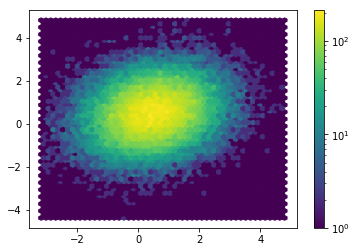

In [6]:
plt.hexbin(x = data_train[:, 0], y = data_train[:, 1], bins = 'log', gridsize = 50)
plt.colorbar()
plt.show()

In [7]:
def MINE_network(data_X, data_Y, name):
    with tf.variable_scope(name):
        data_Y_shuffled = tf.random.shuffle(data_Y)
    
        data_X_combined = tf.concat([data_X, data_X], axis = 0)
        data_Y_combined = tf.concat([data_Y, data_Y_shuffled], axis = 0)
        data_combined = tf.concat([data_X_combined, data_Y_combined], axis = 1)
        
        lay = layers.relu(data_combined, 20)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)
        
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)
    
    return outputs, these_vars

In [8]:
def MINE_loss(MINE_output, name):
    with tf.variable_scope(name):
        batch_size_dyn = tf.cast(tf.math.divide(tf.shape(MINE_output)[0], 2), tf.int32)
        T_xy = MINE_output[:batch_size_dyn,:]
        T_x_y = MINE_output[batch_size_dyn:,:]
        MINE_loss = -(tf.reduce_mean(T_xy, axis = 0) - tf.math.log(tf.reduce_mean(tf.math.exp(T_x_y), axis = 0)))
        MINE_loss = MINE_loss[0]
        
    return MINE_loss

In [9]:
def filter_network(filter_input):
    with tf.variable_scope("filter"):
        lay = layers.relu(filter_input, 20)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)
        
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = "filter")

    return outputs, these_vars

In [10]:
# prepare input tensors
data_in = tf.placeholder(tf.float32, [None, 2], name = 'data_in')
nuisances_in = tf.placeholder(tf.float32, [None, 1], name = 'nuisances_in')
pois_in = tf.placeholder(tf.float32, [None, 1], name = 'pois_in')

In [11]:
filter_output, filter_vars = filter_network(data_in)

In [12]:
# prepare the two MINE blocks connected to the filter output
MINE_output_nuis, MINE_vars_nuis = MINE_network(filter_output, nuisances_in, "MINE_nuis")
MINE_output_pois, MINE_vars_pois = MINE_network(filter_output, pois_in, "MINE_pois")

In [13]:
# upon convergence, the MINE losses below give the negative mutual information
MINE_loss_nuis = MINE_loss(MINE_output_nuis, "MINE_loss_nuis")
MINE_loss_pois = MINE_loss(MINE_output_pois, "MINE_loss_pois")

In [14]:
# MINE optimizers
train_MINE_pois = tf.train.AdamOptimizer(learning_rate = 0.01, beta1 = 0.3, beta2 = 0.5).minimize(MINE_loss_nuis, var_list = MINE_vars_nuis)
train_MINE_nuis = tf.train.AdamOptimizer(learning_rate = 0.01, beta1 = 0.3, beta2 = 0.5).minimize(MINE_loss_pois, var_list = MINE_vars_pois)

In [15]:
total_loss = MINE_loss_pois - MINE_loss_nuis

In [16]:
# filter optimizer
train_filter = tf.train.AdamOptimizer(learning_rate = 0.005, beta1 = 0.3, beta2 = 0.5).minimize(total_loss, var_list = filter_vars)

In [17]:
sess.run(tf.global_variables_initializer())

In [18]:
MINE_init_epochs = 200
batches_per_epoch = 200
number_epochs = 10
batch_size = 200

In [19]:
# pre-train MINE blocks
for epoch in range(MINE_init_epochs):
    sess.run(train_MINE_pois, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, pois_in: pois_train})
    sess.run(train_MINE_nuis, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, pois_in: pois_train})

In [20]:
# initial MI values        
MI_pois = -sess.run(MINE_loss_pois, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, pois_in: pois_train})
MI_nuis = -sess.run(MINE_loss_nuis, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, pois_in: pois_train})

print("MI_nuis = {}, MI_pois = {}".format(MI_nuis, MI_pois))

MI_nuis = 0.004088163375854492, MI_pois = 0.003579378128051758


In [21]:
for epochs in range(number_epochs):
    for batch in range(batches_per_epoch):
        # prepare batch training data
        inds = np.random.choice(len(data_train), batch_size)
        data_batch = data_train[inds]
        pois_batch = pois_train[inds]
        nuis_batch = nuisances_train[inds]

        # update MINE
        sess.run(train_MINE_pois, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, pois_in: pois_train})
        sess.run(train_MINE_nuis, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, pois_in: pois_train})

        # update filter
        sess.run(train_filter, feed_dict = {data_in: data_batch, nuisances_in: nuis_batch, pois_in: pois_batch})

        if not batch % 100:
            # debug output
            MI_pois = -sess.run(MINE_loss_pois, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, pois_in: pois_train})
            MI_nuis = -sess.run(MINE_loss_nuis, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, pois_in: pois_train})

            print("MI_nuis = {}, MI_pois = {}".format(MI_nuis, MI_pois))

MI_nuis = -0.00028121471405029297, MI_pois = 0.004014015197753906
MI_nuis = 1.2636184692382812e-05, MI_pois = 0.03636789321899414
MI_nuis = 0.002212047576904297, MI_pois = 0.03926515579223633
MI_nuis = 0.0002636909484863281, MI_pois = 0.03872871398925781
MI_nuis = 0.0013799667358398438, MI_pois = 0.03891706466674805
MI_nuis = 0.001667022705078125, MI_pois = 0.039446353912353516
MI_nuis = 0.0005464553833007812, MI_pois = 0.037764549255371094
MI_nuis = 0.00013446807861328125, MI_pois = 0.04084300994873047
MI_nuis = 0.000244140625, MI_pois = 0.03957557678222656
MI_nuis = -0.00035858154296875, MI_pois = 0.03872394561767578
MI_nuis = -3.528594970703125e-05, MI_pois = 0.040144920349121094
MI_nuis = 0.0002040863037109375, MI_pois = 0.039864540100097656
MI_nuis = 0.000659942626953125, MI_pois = 0.03738880157470703
MI_nuis = 0.0009469985961914062, MI_pois = 0.039420127868652344
MI_nuis = 0.0002803802490234375, MI_pois = 0.038097381591796875
MI_nuis = 0.0014801025390625, MI_pois = 0.037492752075

In [22]:
# look at the filter output as a function of the incoming random variable
data_test = np.random.uniform(low = -4, high = 4, size = [50000, 2])

In [23]:
pred = sess.run(filter_output, feed_dict = {data_in: data_test})

In [24]:
def plot_contour(data_xy, data_z, x_low = -4, x_high = 4 , y_low = -4, y_high = 4):
    from matplotlib.mlab import griddata
    
    xi = np.linspace(x_low, x_high, 1000)
    yi = np.linspace(y_low, y_high, 1000)
    zi = griddata(data_xy[:, 0], data_xy[:, 1], data_z, xi, yi, interp = "linear")

    plt.contourf(xi, yi, zi, interp='linear', levels = 100)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()

In [25]:
plot_contour(data_test, pred.flatten())

/usr/lib/python3/dist-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: The griddata function was deprecated in Matplotlib 2.2 and will be removed in 3.1. Use scipy.interpolate.griddata instead.
/home/philipp/.local/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'interp'
  s)


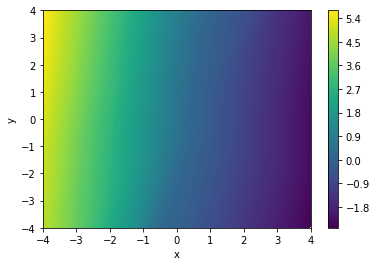

In [26]:
plt.show()